In [2]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm

# Define colors
phillies_red  = np.divide((232, 24, 40),255)
phillies_blue = np.divide((0, 45, 114),255)


In [3]:
# Load statcast data or download directly. NOTE: THIS TAKES A WHILE TO GET ALL DATA
load_statcast_data = False

In [4]:
def add_mlb_id(temp,_players):
    temp["key_mlbam"] = _players.loc[_players.key_fangraphs.isin([temp.playerid]),"key_mlbam"].item()
    return temp

# Load data as bd -> short for batting data
bd = pd.read_csv("./data/batting.csv")

# Convert and % str to float
cols = [col for col in bd.columns if '%' in col] + ["MarApr_HR/FB"]
for col in cols:
    bd[col] = bd[col].str.rstrip('%').astype('float') / 100.0

# Get data for matching IDs    
_players = pybaseball.playerid_reverse_lookup(bd.playerid.tolist(),key_type='fangraphs')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Get MLB id
bd = bd.apply(lambda temp: add_mlb_id(temp,_players),axis=1)
bd.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP,key_mlbam
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.057,0.400,0.226,0.660,0.407,0.811,0.884,0.860,0.406,641355
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.118,0.412,0.279,0.724,0.448,0.566,0.878,0.757,0.429,592885
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.000,0.222,0.402,0.745,0.535,0.543,0.854,0.711,0.315,664068
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.000,0.200,0.273,0.505,0.373,0.939,0.978,0.962,0.353,519299
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.074,0.296,0.237,0.488,0.337,0.661,0.827,0.757,0.341,596129


In [5]:
# Add data to dataframe
def get_statcast_data(temp,start_dt='2015-04-05', end_dt='2019-11-30'):

    # Get player data
    data = pybaseball.statcast_batter(start_dt=start_dt, end_dt=end_dt,player_id=temp.key_mlbam)
    
    # Keep only regular season data
    data = data.loc[data.game_type.isin(["R"]),:]

    # group by date
    grouped = data.groupby(by="game_date")
    
    # Create empty dataframe
    out = pd.DataFrame()
    for name, group in grouped:
        # Create empty dataframe
        temp = pd.DataFrame()

        # Get name
        temp["player_name"] = [group.player_name.unique()[0]]

        # Get batter MLB ID
        temp["batter"] = [group.batter.unique()[0]]

        # Save date
        temp["game_date"] = [name]
        temp["year"]      = [pd.to_datetime(group.game_date.unique()[0]).year]

        # Some more advanced metrics
        temp["launch_angle"]  = [group.launch_angle.mean(skipna=True)]
        temp["launch_speed"]  = [group.launch_speed.mean(skipna=True)]
        temp["release_speed"] = [group.release_speed.mean(skipna=True)]
        temp["xBA"]           = [group.estimated_ba_using_speedangle.mean(skipna=True)]
        temp["xwOBA"]         = [group.estimated_woba_using_speedangle.mean(skipna=True)]
        temp["wOBA"]          = [group.woba_value.mean(skipna=True)]
        temp["BABIP"]         = [group.babip_value.mean(skipna=True)]
        temp["ISO"]           = [group.iso_value.mean(skipna=True)]

        # Get counts
        counts = group.events.value_counts()

        # Get values for computing OBP
        which_events = ["single","double","triple","home_run","walk","hit_by_pitch","sac_fly","strikeout","field_out","field_error"]#,"grounded_into_double_play","force_out"]
        event_names  = ["B1","B2","B3","HR","BB","HBP","SF","K","FieldOut","FieldErr"]#,"GIDP",,"ForceOut"]
        for (event,event_name) in zip(which_events,event_names):
            temp[event_name]  = counts[event].item() if event in counts else 0

        # Compute new OBP
        temp["H"]   = temp.B1 + temp.B2 + temp.B3 + temp.HR
        temp["AB"]  = temp.H +  temp.K + temp.FieldOut + temp.FieldErr# +temp.GIDP + temp.ForceOut
        temp["OB"]  = (temp.H + temp.BB + temp.HBP)
        temp["TA"]  = (temp.AB + temp.BB + temp.HBP + temp.SF)
        temp["OBP"] = (temp.OB / temp.TA) if (temp.TA > 0).bool() else 0

        # Add slugging percentage 
        temp["Slg"] = (temp.B1 + 2*temp.B2 + 3*temp.B3 + 4*temp.HR)/temp.AB

        # Concatenate to outer dataframe
        out  = pd.concat([out,temp],axis=0)
    return out

#######################################
#                                     #
#        LOAD/DOWNLOAD STATCAST       #
#       (very slow to download!)      #
#                                     #
#######################################
if not load_statcast_data:
    sd = pd.DataFrame() # <--- sd: statcast data
    for row in bd.itertuples():
        temp = get_statcast_data(row)
        sd = pd.concat([sd,temp])

    # Reset index
    sd = sd.reset_index()

    # Save dataframe
    sd.to_pickle("./data/forecasting_data_2015-2019.pkl")
else:
    sd = pd.read_pickle("./data/forecasting_data_2015-2019.pkl")

sd


,index,player_name,batter,game_date,year,launch_angle,launch_speed,release_speed,xBA,xwOBA,...,SF,K,FieldOut,FieldErr,H,AB,OB,TA,OBP,Slg
0,0,"Bellinger, Cody",641355,2017-04-25,2017,16.250000,76.000000,86.725000,0.268667,0.247000,...,0,0,2,0,1,3,1,3,0.333333,0.333333
1,0,"Bellinger, Cody",641355,2017-04-26,2017,63.285714,80.914286,88.581481,0.090000,0.108000,...,0,3,2,0,0,5,0,5,0.000000,0.000000
2,0,"Bellinger, Cody",641355,2017-04-27,2017,55.333333,67.133333,90.427778,NaN,NaN,...,0,2,0,0,0,2,1,3,0.333333,0.000000
3,0,"Bellinger, Cody",641355,2017-04-28,2017,2.750000,66.475000,85.346667,0.313333,0.285333,...,0,0,1,0,2,3,3,4,0.750000,0.666667
4,0,"Bellinger, Cody",641355,2017-04-29,2017,20.200000,96.180000,91.423077,0.608250,1.039000,...,0,0,2,0,2,4,2,4,0.500000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143893,0,"Allen, Greg",656185,2019-09-25,2019,NaN,NaN,96.600000,NaN,NaN,...,0,1,0,0,0,1,0,1,0.000000,0.000000
143894,0,"Allen, Greg",656185,2019-09-26,2019,15.500000,70.975000,83.592308,0.391333,0.352000,...,0,0,1,1,1,3,1,3,0.333333,0.333333
143895,0,"Allen, Greg",656185,2019-09-27,2019,8.666667,82.933333,88.187500,0.553333,0.510000,...,0,0,2,0,1,3,1,3,0.333333,0.333333
143896,0,"Allen, Greg",656185,2019-09-28,2019,NaN,NaN,85.740000,NaN,NaN,...,0,0,0,0,0,0,1,1,1.000000,NaN


In [34]:
from pybaseball import batting, pitching

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name


# Get the data
batting_data = batting()
pitching_data = pitching()

# Remove unneeded columns
rows_to_keep = (batting_data.AB > 0) & (batting_data.yearID < 2019) #& (batting_data.lgID == "NL") 
# cols_to_keep = ["AB","H","BB","HBP","SF","HR","playerID","yearID"]

# Add the player's name for ease of reading
batting_data = batting_data.loc[rows_to_keep ,:]
batting_data.dropna(inplace=True)

# Add batting average
batting_data["Avg"] = batting_data.H / batting_data.AB

# Add OBP
batting_data["OBP"] = (batting_data.H + batting_data.BB + batting_data.HBP) / (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF)

# Add on base (OB), no base (NB), and total appearances (TA) -- not quite PA since we are only counting those considered in OBP
batting_data["OB"] = (batting_data.H + batting_data.BB + batting_data.HBP)
batting_data["TA"] = (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF)
batting_data["NB"] = (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF) - (batting_data.H + batting_data.BB + batting_data.HBP)

# Add singles and compute slg
batting_data["1B"] = batting_data.H - (batting_data["2B"] + batting_data["3B"] + batting_data.HR)
batting_data["Slg"] = (batting_data["1B"] + 2*batting_data["2B"] + 3*batting_data["3B"] + 4*batting_data.HR)/batting_data.AB

# Change order
# batting_data = batting_data.loc[:,["playerID","yearID","AB","H","BB","HBP","SF","HR","Avg","OBP","OB","NB","TA"]]

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.unique().tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Group by player
grouped = batting_data.groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "BB": "sum", "HBP": "sum", "SF": "sum", "yearID": "mean","OBP": "mean", "Slg": "mean"}).reset_index()#.sum().reset_index()
grouped["yearID"] = grouped["yearID"].astype("int")

# Is pitcher?
grouped.loc[:,"Pitcher"] = grouped.playerID.isin(pitching_data.loc[pitching_data.G > 5,"playerID"])

# Add name
grouped["Name"] = grouped.apply(lambda row: add_name(row.playerID),axis=1)


In [47]:
grouped["OPS"] = grouped["OBP"] + grouped["Slg"]
grouped["OBP2SLG"] = grouped["OBP"]/grouped["Slg"]

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_34732/1579920431.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot)#,ticks=cbar_ticks)


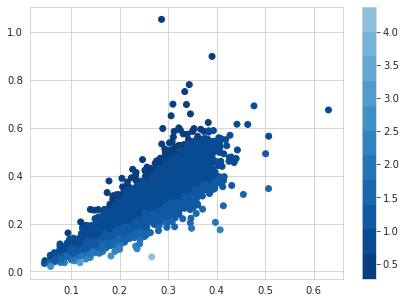

In [48]:
import matplotlib as mpl 

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])
    # cmap = mpl.cm.Blues_r(np.linspace(0,1,20))[1:12]
    # cmapbins = np.logspace(0,5,len(cmap))

    #### NOT PITCHER ####
    # Plot scatter 
    splot = ax.scatter(grouped.loc[(grouped.AB > 100),"OBP"],grouped.loc[(grouped.AB > 100),"Slg"],c=grouped.loc[(grouped.AB > 100), "OBP2SLG"],cmap=cmap,norm=mpl.colors.Normalize())
    
    # ax[0].set_ylim(0,0.5)
    # ax[0].set_yticks(np.arange(0,0.6,0.1))
    # ax[0].set_xlabel("OBP",fontweight="bold")
    # ax[0].set_ylabel("EB Estimate OBP",fontweight="bold")
    # ax[0].legend(frameon=False)
    # ax[0].set_title("Non-Pitcher")


    # Clean up
    # cbar_ticks = [0,1,2,3,4,5]
    cbar = plt.colorbar(splot)#,ticks=cbar_ticks)
    # cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("",rotation=0,fontweight="bold")
    